In [9]:
import os
import cv2
import numpy as np
import shutil
import random
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Config
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50  # longer for fine-tuning


In [10]:
def load_bgr(path):
    """Load image from disk in BGR format (OpenCV default)."""
    return cv2.imread(path)

def largest_object_crop(bgr):
    """Crop the largest object in the image."""
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    th = cv2.adaptiveThreshold(blur, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 21, 5)
    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return bgr
    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    crop = bgr[y:y+h, x:x+w]
    return crop if crop.size else bgr

def preprocess_for_model(bgr):
    """Resize + normalize the image for the classifier."""
    crop = largest_object_crop(bgr)
    rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, IMG_SIZE)
    x = rgb.astype(np.float32) / 255.0
    return x


In [11]:
DATASET_DIR = "/kaggle/input/waste-data/garbage_classification"  # your raw dataset folder
OUTPUT_DIR = "data"  # output folder for train/test split
SPLIT_RATIO = 0.8

os.makedirs(os.path.join(OUTPUT_DIR, "train"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "test"), exist_ok=True)

for category in os.listdir(DATASET_DIR):
    category_path = os.path.join(DATASET_DIR, category)
    if not os.path.isdir(category_path):
        continue

    images = os.listdir(category_path)
    random.shuffle(images)

    split_index = int(len(images) * SPLIT_RATIO)
    train_images = images[:split_index]
    test_images = images[split_index:]

    os.makedirs(os.path.join(OUTPUT_DIR, "train", category), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, "test", category), exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(category_path, img),
                    os.path.join(OUTPUT_DIR, "train", category, img))
    for img in test_images:
        shutil.copy(os.path.join(category_path, img),
                    os.path.join(OUTPUT_DIR, "test", category, img))

print("✅ Dataset split completed!")


✅ Dataset split completed!


In [12]:
train_dir = "data/train"
val_dir = "data/test"  # or "data/val" if you have a validation folder

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # optional
    fill_mode='nearest'
)

# Validation generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Save class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes = [class_indices[i] for i in range(len(class_indices))]
print("✅ Classes:", classes)


Found 8007 images belonging to 12 classes.
Found 2005 images belonging to 12 classes.
✅ Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [13]:
# Load base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet"
)

# Fine-tune deeper layers
base_model.trainable = True
for layer in base_model.layers[:30]:  # freeze only very low-level layers
    layer.trainable = False

# Build classifier head with Dropout
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(classes), activation="softmax")
])

# Compile model with small LR
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


I0000 00:00:1758647310.321489      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758647310.322199      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,590,028 (9.88 MB)

 Trainable params: 2,535,868 (9.67 MB)

 Non-trainable params: 54,160 (211.56 KB)

In [14]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
checkpoint = ModelCheckpoint("models/best_model.h5", save_best_only=True)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1758647368.023031     145 service.cc:148] XLA service 0x7ce3500037f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758647368.024824     145 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758647368.024850     145 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758647371.017619     145 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/251 ━━━━━━━━━━━━━━━━━━━━ 3:27:58 50s/step - accuracy: 0.1562 - loss: 3.0562

I0000 00:00:1758647387.382458     145 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 154s 418ms/step - accuracy: 0.4059 - loss: 2.0140 - val_accuracy: 0.7292 - val_loss: 0.9079 - learning_rate: 1.0000e-04
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 84s 335ms/step - accuracy: 0.7906 - loss: 0.6422 - val_accuracy: 0.8000 - val_loss: 0.6983 - learning_rate: 1.0000e-04
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 86s 341ms/step - accuracy: 0.8513 - loss: 0.4684 - val_accuracy: 0.8429 - val_loss: 0.5548 - learning_rate: 1.0000e-04
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 338ms/step - accuracy: 0.8731 - loss: 0.3912 - val_accuracy: 0.8858 - val_loss: 0.4261 - learning_rate: 1.0000e-04
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 86s 343ms/step - accuracy: 0.8936 - loss: 0.3336 - val_accuracy: 0.9032 - val_loss: 0.3431 - learning_rate: 1.0000e-04
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - accuracy: 0.9041 - loss: 0.2878 - val_accuracy: 0.9132 - val_loss: 0.2943 - learning_rate: 1.0000e-04
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step -

In [15]:
# === 2. Print final accuracies ===
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"📊 Final Training Accuracy: {final_train_acc:.4f}")
print(f"📊 Final Validation Accuracy: {final_val_acc:.4f}")

📊 Final Training Accuracy: 0.9763
📊 Final Validation Accuracy: 0.9521


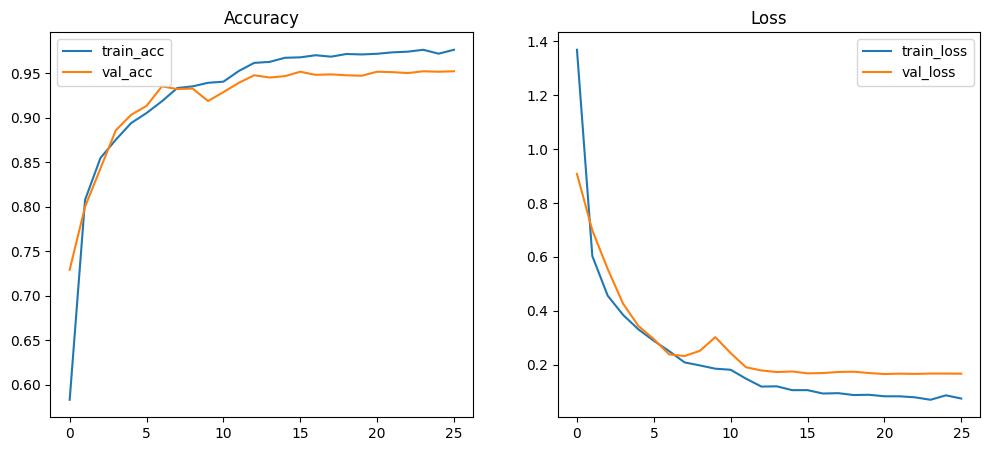

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.show()


In [17]:
model.save("/kaggle/working/final_model.h5")

Saved HDF5 model to models/final_model.h5
Failed to save TF SavedModel: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf
Loaded model from checkpoint: models/best_model.h5
Found 2005 images belonging to 12 classes.
Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step
Classification report:

              precision    recall  f1-score   support

     battery       0.98      0.95      0.96       189
  biological       0.98      0.97      0.98       197
 brown-glass       0.98      0.93      0.95       122
   cardboard       0.96      0.97      0.96       179
     clothes       0.96      0.99      0.98       189
 green-glass       0.96      0.99      0.98       126
       metal       0.90      0.96      0.93       154
       paper      

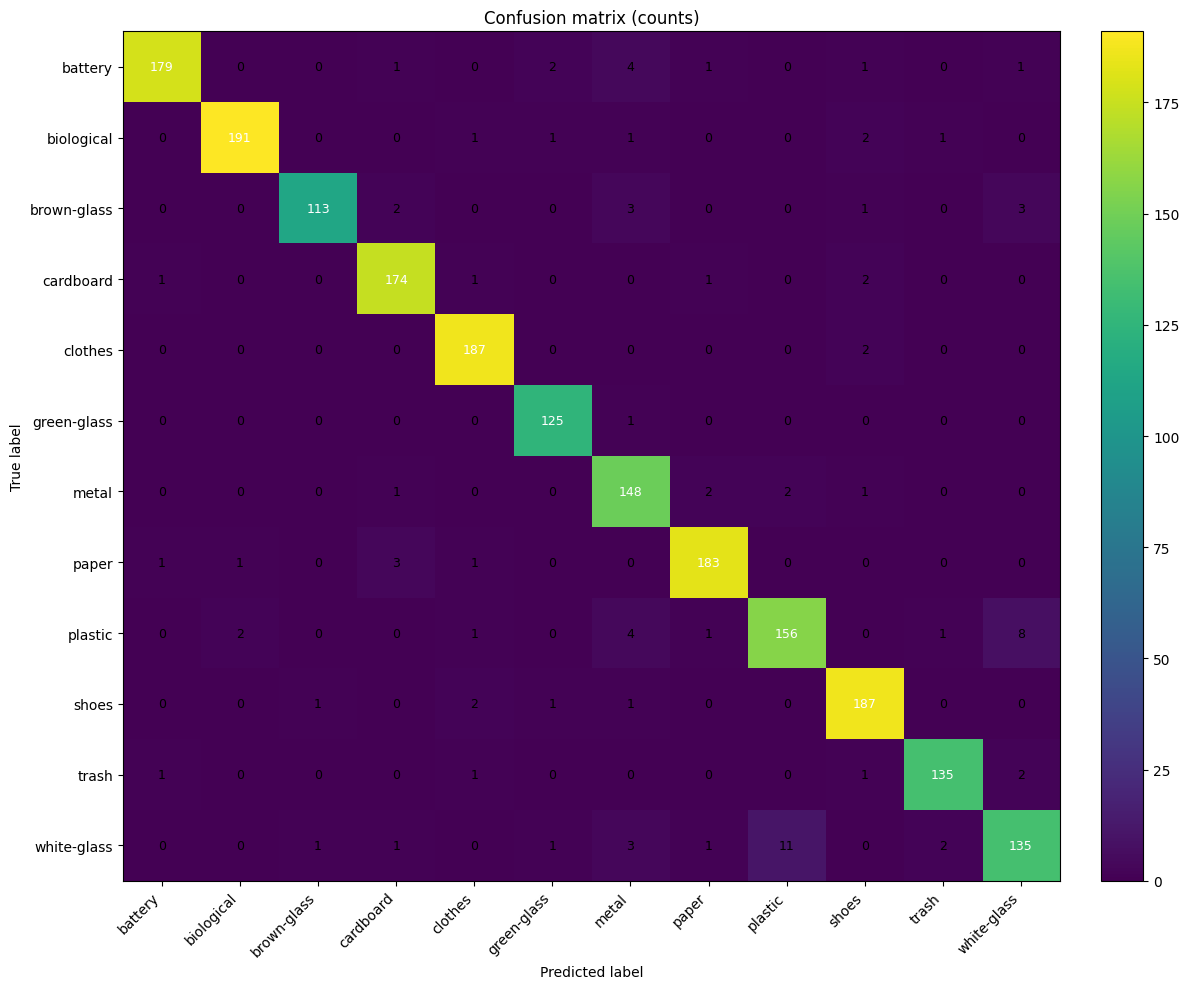

Saved: outputs/confusion_matrix_normalized.png


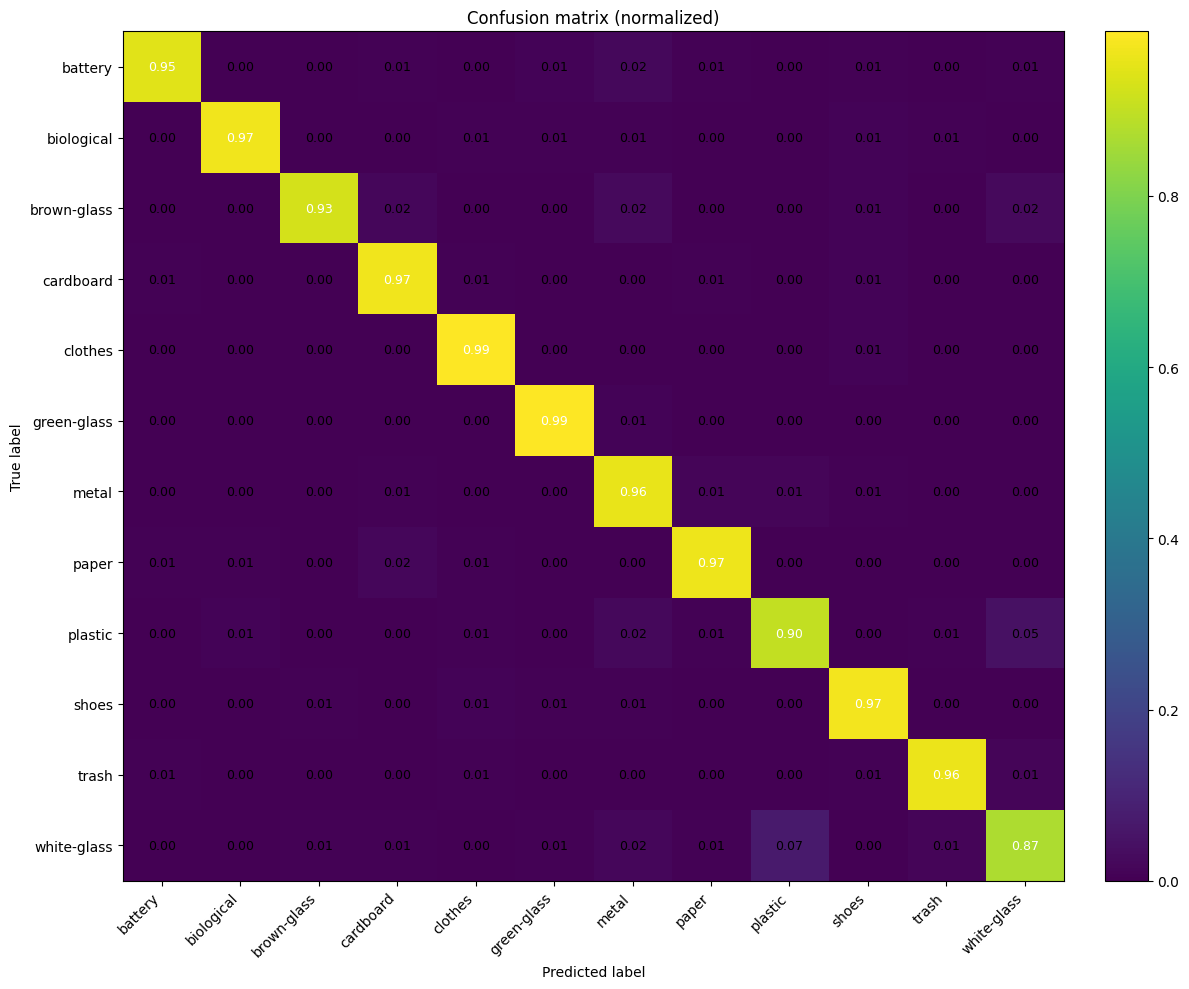

In [9]:
# ======= Save model + Confusion Matrix plotting for Kaggle =======
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Ensure folders
os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

# 1) Save the model (HDF5 and SavedModel)
# If you want to save the current in-memory model:
try:
    model.save("models/final_model.h5")
    print("Saved HDF5 model to models/final_model.h5")
except Exception as e:
    print("Failed to save HDF5 model:", e)

# Also save as TensorFlow SavedModel (recommended)
try:
    model.save("models/saved_model", save_format="tf")
    print("Saved TF SavedModel to models/saved_model/")
except Exception as e:
    print("Failed to save TF SavedModel:", e)

# Optionally: if you used ModelCheckpoint earlier and prefer to evaluate that:
checkpoint_path = "models/best_model.h5"
if os.path.exists(checkpoint_path):
    try:
        model = tf.keras.models.load_model(checkpoint_path)
        print(f"Loaded model from checkpoint: {checkpoint_path}")
    except Exception as e:
        print("Could not load checkpoint; continuing with current model in memory.", e)

# 2) Recreate validation generator with shuffle=False so labels align with predictions
# (val_datagen, IMG_SIZE, BATCH_SIZE and val_dir should already be defined in your notebook)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 3) Prepare class names (consistent with train_generator)
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print("Classes:", class_names)

# 4) Predict on validation set
steps = math.ceil(val_generator.samples / val_generator.batch_size)
y_prob = model.predict(val_generator, steps=steps, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = val_generator.classes

# 5) Compute confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("Classification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# 6) Plot functions (counts + normalized)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', figsize=(10, 8), savepath=None):
    if normalize:
        # avoid division by zero
        row_sums = cm.sum(axis=1)[:, np.newaxis]
        cm_to_plot = cm.astype('float') / np.where(row_sums == 0, 1, row_sums)
    else:
        cm_to_plot = cm

    plt.figure(figsize=figsize)
    plt.imshow(cm_to_plot, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm_to_plot.max() / 2. if cm_to_plot.max() != 0 else 0.5
    for i, j in itertools.product(range(cm_to_plot.shape[0]), range(cm_to_plot.shape[1])):
        val = cm_to_plot[i, j]
        plt.text(j, i, format(val, fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if val > thresh else "black",
                 fontsize=9)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
        print("Saved:", savepath)
    plt.show()

# Plot raw counts
plot_confusion_matrix(cm, class_names, normalize=False,
                      title='Confusion matrix (counts)',
                      figsize=(12, 10),
                      savepath="outputs/confusion_matrix_counts.png")

# Plot normalized (per-row)
plot_confusion_matrix(cm, class_names, normalize=True,
                      title='Confusion matrix (normalized)',
                      figsize=(12, 10),
                      savepath="outputs/confusion_matrix_normalized.png")


✅ Loaded model from /kaggle/working/final_model.h5
Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


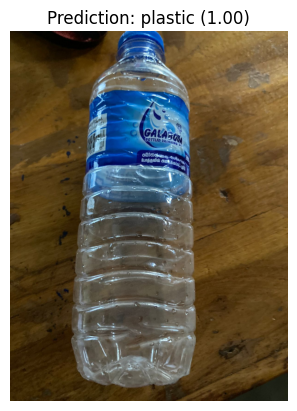

Predicted: plastic Confidence: 0.99986076


In [20]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ===== Load trained model =====
model_path = "/kaggle/working/final_model.h5"   # or "models/final_model.h5"
model = tf.keras.models.load_model(model_path)
print(f"✅ Loaded model from {model_path}")

# ===== Class names (use same as training) =====
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print("Classes:", class_names)

# ===== Function to predict a single image =====
def predict_single_image(img_path):
    # Load with OpenCV
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise ValueError(f"Could not load image: {img_path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb, IMG_SIZE)  # same as training size
    x = resized.astype(np.float32) / 255.0
    x = np.expand_dims(x, axis=0)  # add batch dimension

    # Prediction
    preds = model.predict(x)
    pred_idx = np.argmax(preds, axis=1)[0]
    pred_class = class_names[pred_idx]
    confidence = preds[0][pred_idx]

    # Show image + prediction
    plt.imshow(rgb)
    plt.axis("off")
    plt.title(f"Prediction: {pred_class} ({confidence:.2f})")
    plt.show()

    return pred_class, confidence

# ===== Example usage =====
test_image_path = "/kaggle/input/testing-for/c056434b-c7b3-4d41-b992-09d0f8a67f35.jpg"  # change to your test image path
pred_class, confidence = predict_single_image(test_image_path)
print("Predicted:", pred_class, "Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


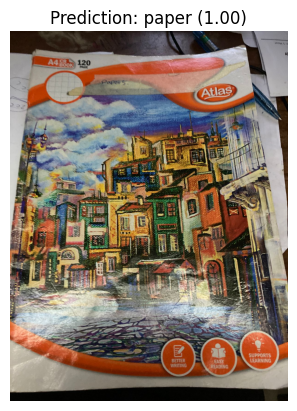

Predicted: paper Confidence: 0.99828076


In [23]:
# ===== Example usage =====
test_image_path = "/kaggle/input/testing-for/fgf.jpg"  # change to your test image path
pred_class, confidence = predict_single_image(test_image_path)
print("Predicted:", pred_class, "Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


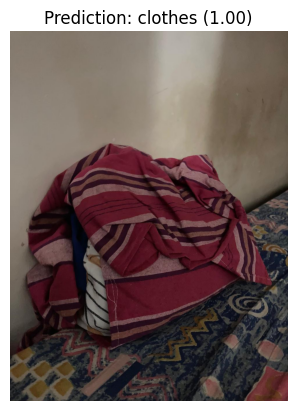

Predicted: clothes Confidence: 0.9999964


In [24]:
# ===== Example usage =====
test_image_path = "/kaggle/input/cllllo/d5695471-2564-431d-b719-e74716d64f98.jpg"  # change to your test image path
pred_class, confidence = predict_single_image(test_image_path)
print("Predicted:", pred_class, "Confidence:", confidence)

In [21]:
# Save inside Kaggle working directory
model.save("/kaggle/working/finaleee.h5")        # HDF5 format
#model.save("/kaggle/working/saved_model", save_format="tf")  # TF SavedModel format

print("✅ Model saved successfully in Kaggle working directory")


✅ Model saved successfully in Kaggle working directory


In [25]:
import tensorflow as tf

# Load the saved .h5 model
model = tf.keras.models.load_model("/kaggle/working/final_model.h5")

# Convert to TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite file
with open("/kaggle/working/model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved at /kaggle/working/model.tflite")


Saved artifact at '/tmp/tmp0oh7ipm0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  137316514414224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137315886167440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137315886165328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137315886164176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137315886165904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137315886167056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137315886163984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137315886168976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137315886168400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137315886169744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137315886167

W0000 00:00:1758654308.766551      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1758654308.766628      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1758654308.928047      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
